In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
Data = pd.read_csv("../input/nlp-getting-started/train.csv")

# Data Exploration 

In this phase I tend to go throw the data, and learn more about it, **the objectives are:**
* Eamin the missing values
* Examin the bias within the data

In [3]:
Data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


As indicated the issue with the missing values is that all the missing values are replaced with "NaN", That is why the examination shows us no missing values.

<AxesSubplot:xlabel='count', ylabel='target'>

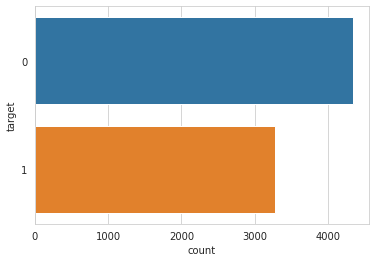

In [5]:
sns.set_style('whitegrid')
sns.countplot(y=Data['target'])

In [6]:
Data['target'].groupby(Data['target']).count()

target
0    4342
1    3271
Name: target, dtype: int64

The data includes 30% more of non disaster observations, which means it is biased to the non disaster tweets

In [7]:
Disaster_key_words = Data[Data.target==1]["keyword"]
None_Disaster_key_words = Data[Data.target==0]["keyword"]

In [8]:
def wordcloudGenerator(word_list, title):
    mostcommon = FreqDist(word_list).most_common(2000)
    wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(str(mostcommon))
    fig = plt.figure(figsize=(30,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50)
    plt.show()

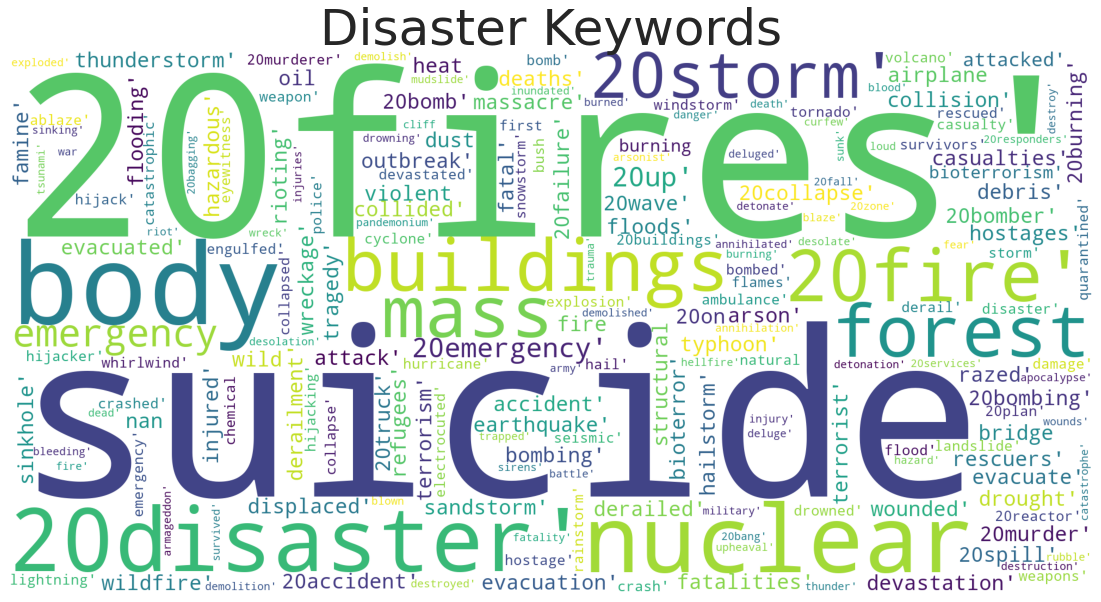

In [9]:
wordcloudGenerator(Disaster_key_words,'Disaster Keywords')

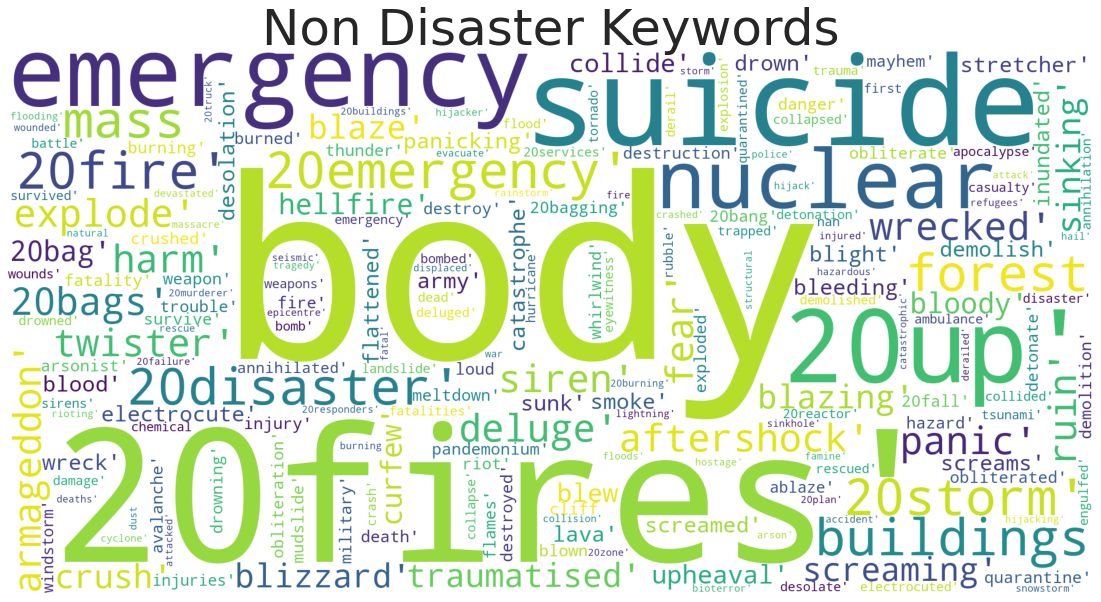

In [10]:
wordcloudGenerator(None_Disaster_key_words,'Non Disaster Keywords')

# Removing the stop words and the punctuation from the tweets

In [11]:
Datav2 = Data.copy()

In [12]:
Datav2['text']  = Datav2['text'].astype('str')

In [13]:
Text2 = list()
for tweet in Datav2['text'] : 
    new_tweet = re.sub(r'[^a-z A-Z]', ' ',tweet)
    Text2.append(new_tweet)
Datav2["text"] = Text2

In [14]:
stop = stopwords.words('english')
Datav2['text'] = Datav2['text'].apply(lambda x: ' '.join([word for word in x.split(" ") if word.lower()  not in (stop)]))

In [15]:
Datav2.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,residents asked shelter place notified offic...,1
3,6,NaN,NaN,people receive wildfires evacuation or...,1
4,7,NaN,NaN,got sent photo Ruby Alaska smoke wildfires p...,1


In [16]:
disaster_tweets_words = []
for sentence in Datav2[Datav2['target']==1]['text']:
    sentence_list = sentence.split()
    for word in sentence_list:
        disaster_tweets_words.append(word)

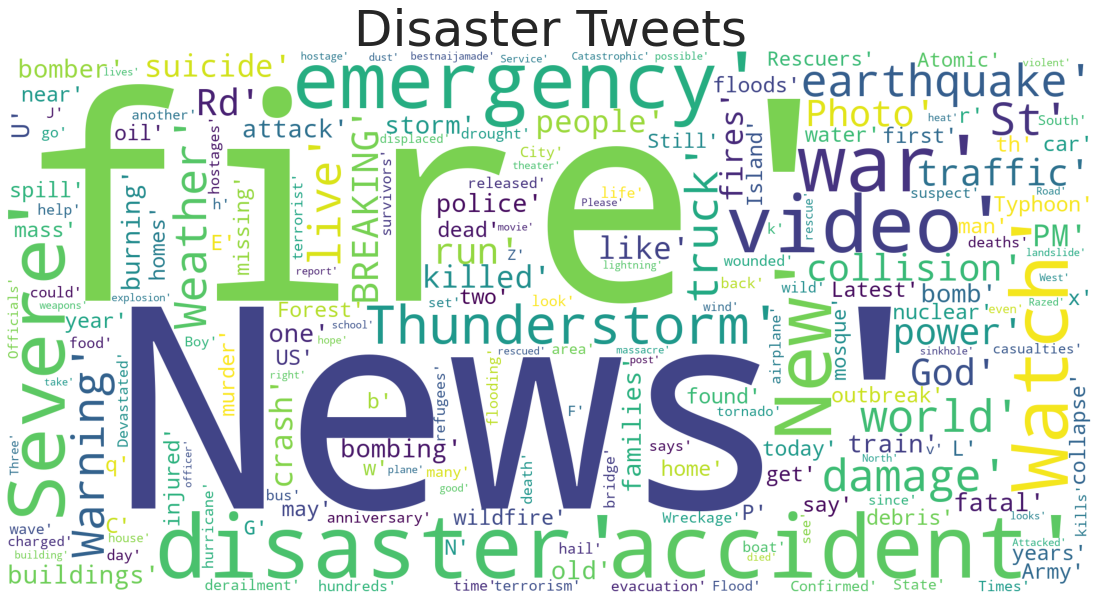

In [17]:
wordcloudGenerator(disaster_tweets_words,'Disaster Tweets')

In [18]:
non_disaster_tweets_words = []        
for sentence in Datav2[Datav2['target']==0]['text']:
    sentence_list = sentence.split()
    for word in sentence_list:
        non_disaster_tweets_words.append(word)

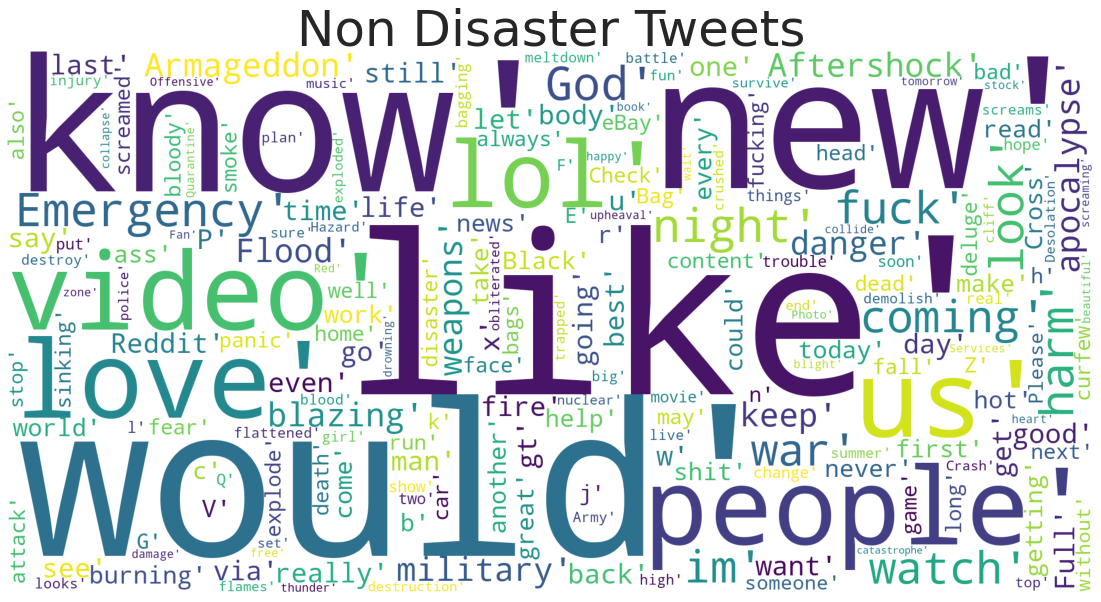

In [19]:
wordcloudGenerator(non_disaster_tweets_words,'Non Disaster Tweets')

In [20]:
tokenizer = Tokenizer(num_words = 23000, oov_token="<OOV>")
tokenizer.fit_on_texts(Datav2.text)

In [21]:
text =pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(Datav2.text.to_numpy()), padding='pre'))
Datav3 = pd.concat([Datav2, text], axis=1)
Datav3 = Datav3.drop("text",axis=1)

In [22]:
Datav3.head()

,id,keyword,location,target,0,1,2,3,4,5,...,17,18,19,20,21,22,23,24,25,26
0,1,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,4602,731,172,76,1469,4603,25
1,4,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,117,7,147,593,6873,6874,1071
2,5,NaN,NaN,1,0,0,0,0,0,0,...,1470,1793,571,6875,1601,173,1793,571,1259,960
3,6,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,0,13,4604,1356,173,1259,31
4,7,NaN,NaN,1,0,0,0,0,0,0,...,0,40,1072,235,6876,1602,184,1356,6877,112


In [23]:
X = Datav3.drop(["target","id","location","keyword"],axis=1).to_numpy().astype('float32')
Y = Datav3['target'].to_numpy().astype('float32')


In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=31))
model.add(tf.keras.layers.LSTM(units=150, recurrent_dropout=0.1, dropout=0.1, return_sequences=False))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()



2022-07-14 21:43:38.246612: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 64)            1406848   
_________________________________________________________________
lstm (LSTM)                  (None, 150)               129000    
_________________________________________________________________
dense (Dense)                (None, 64)                9664      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,547,625
Trainable params: 1,547,625
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = model.fit(X, Y, epochs=7,batch_size = 20, validation_split=0.2, shuffle=True)

2022-07-14 21:43:38.725449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7
305/305 [==============================] - 44s 129ms/step - loss: 0.6467 - accuracy: 0.6115 - precision: 0.5659 - recall: 0.3286 - val_loss: 0.6213 - val_accuracy: 0.6953 - val_precision: 0.6853 - val_recall: 0.6389
Epoch 2/7
305/305 [==============================] - 38s 123ms/step - loss: 0.5818 - accuracy: 0.6995 - precision: 0.6475 - recall: 0.6272 - val_loss: 0.5440 - val_accuracy: 0.7400 - val_precision: 0.8501 - val_recall: 0.5360
Epoch 3/7
305/305 [==============================] - 38s 124ms/step - loss: 0.4539 - accuracy: 0.7966 - precision: 0.7968 - recall: 0.6932 - val_loss: 0.4903 - val_accuracy: 0.7597 - val_precision: 0.7489 - val_recall: 0.7278
Epoch 4/7
305/305 [==============================] - 37s 123ms/step - loss: 0.3940 - accuracy: 0.8319 - precision: 0.8391 - recall: 0.7428 - val_loss: 0.4909 - val_accuracy: 0.7768 - val_precision: 0.8789 - val_recall: 0.6037
Epoch 5/7
305/305 [==============================] - 37s 120ms/step - loss: 0.3504 - accuracy: 0

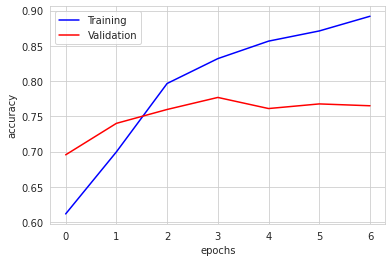

In [26]:
plt.plot(hist.history["accuracy"], color="b")
plt.plot(hist.history["val_accuracy"], color="r")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [27]:
def compute_metrics(labels, pred):
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [28]:
Data_test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [29]:
Data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [30]:
Text2 = list()
for tweet in Data_test['text'] : 
    new_tweet = re.sub(r'[^a-z A-Z]', ' ',tweet)
    Text2.append(new_tweet)

stop = stopwords.words('english')
Data_test['text'] = Data_test['text'].apply(lambda x: ' '.join([word for word in x.split(" ") if word.lower()  not in (stop)]))
Data_test["text"] = Text2
tokenizer2 = Tokenizer(num_words = 23000, oov_token="<OOV>")
tokenizer2.fit_on_texts(Data_test.text)
text2 =pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(Data_test.text.to_numpy()), padding='pre'))

In [31]:
text2

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,36,576,6,984,146,110
1,0,0,0,0,0,0,0,0,0,0,...,0,286,59,266,13,1907,1090,742,888,449
2,0,0,0,0,0,0,0,0,0,0,...,25,4066,985,5,533,10,1273,450,105,45
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,287,2582,4067,1091
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,288,743,253,8,308,11,1518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,266,632,2752,2753,632,12633,12634
3259,0,0,0,0,0,0,0,109,8,12635,...,348,34,16,29,603,295,119,102,426,605
3260,0,0,0,0,0,0,0,0,0,0,...,0,714,315,730,8,821,4,2,3,12636
3261,0,0,0,0,0,0,0,0,0,0,...,697,487,358,2484,2485,4,2,3,92,12637


In [32]:
predictions = list()
pred = model.predict(text2)
for prob in pred:
    if prob[0] > .7 :
        predictions.append(1)
    else : 
        predictions.append(0)

In [33]:
Id = Data_test.id

In [34]:
submission = pd.DataFrame(columns = ['id','target'])
submission['id'], submission['target'] = Id,predictions

In [35]:
submission.to_csv('submission.csv', index=False)